In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [2]:
import math
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Altitools
from alti_tools._src.data.ssh import download_ssh_toy
from alti_tools._src.transforms import spatial, temporal
from alti_tools._src.viz import psd as psd_plots

import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)

try:
    import powerspec as ps
except ModuleNotFoundError:
    !pip install powerspec
    import powerspec as ps  

import xarray as xr
import pandas as pd
from scipy import ndimage
import holoviews as hv
import xrft
from dask.diagnostics import ProgressBar

import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# simulation dataset
ref_ds = xr.open_dataset("/Volumes/EMANS_HDD/data/osse_oceanix/raw/sim/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc", decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))

# Pseudo-Observations
obs_ds = xr.open_dataset('/Volumes/EMANS_HDD/data/osse_oceanix/raw/obs/dataset_nadir_0d_swot.nc')

# DUACS dataset
oi_ds = xr.open_dataset('/Volumes/EMANS_HDD/data/osse_oceanix/raw/results/duacs/ssh_NATL60_swot_4nadir.nc')

In [4]:
ref_ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

In [5]:
obs_ds

<xarray.Dataset>
Dimensions:      (lat: 201, lon: 201, time: 365)
Coordinates:
  * lon          (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat          (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * time         (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    mask         (lat, lon) float64 ...
    lag          (time, lat, lon) float64 ...
    flag         (time, lat, lon) float64 ...
    ssh_obs      (time, lat, lon) float64 ...
    ssh_mod      (time, lat, lon) float64 ...
    anomaly_obs  (time, lat, lon) float64 ...
    anomaly_mod  (time, lat, lon) float64 ...

In [6]:
oi_ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh_mod  (time, lat, lon) float64 ...
    ssh_obs  (time, lat, lon) float64 ...

In [7]:
ds = xr.Dataset({
    'natl60': ref_ds.ssh,
    'oi': oi_ds.ssh_mod,
    'obs': obs_ds.ssh_mod,
})
ds


<xarray.Dataset>
Dimensions:  (lon: 201, lat: 201, time: 365)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    natl60   (time, lat, lon) float64 ...
    oi       (time, lat, lon) float64 ...
    obs      (time, lat, lon) float64 ...

## Viz

### SSH Field

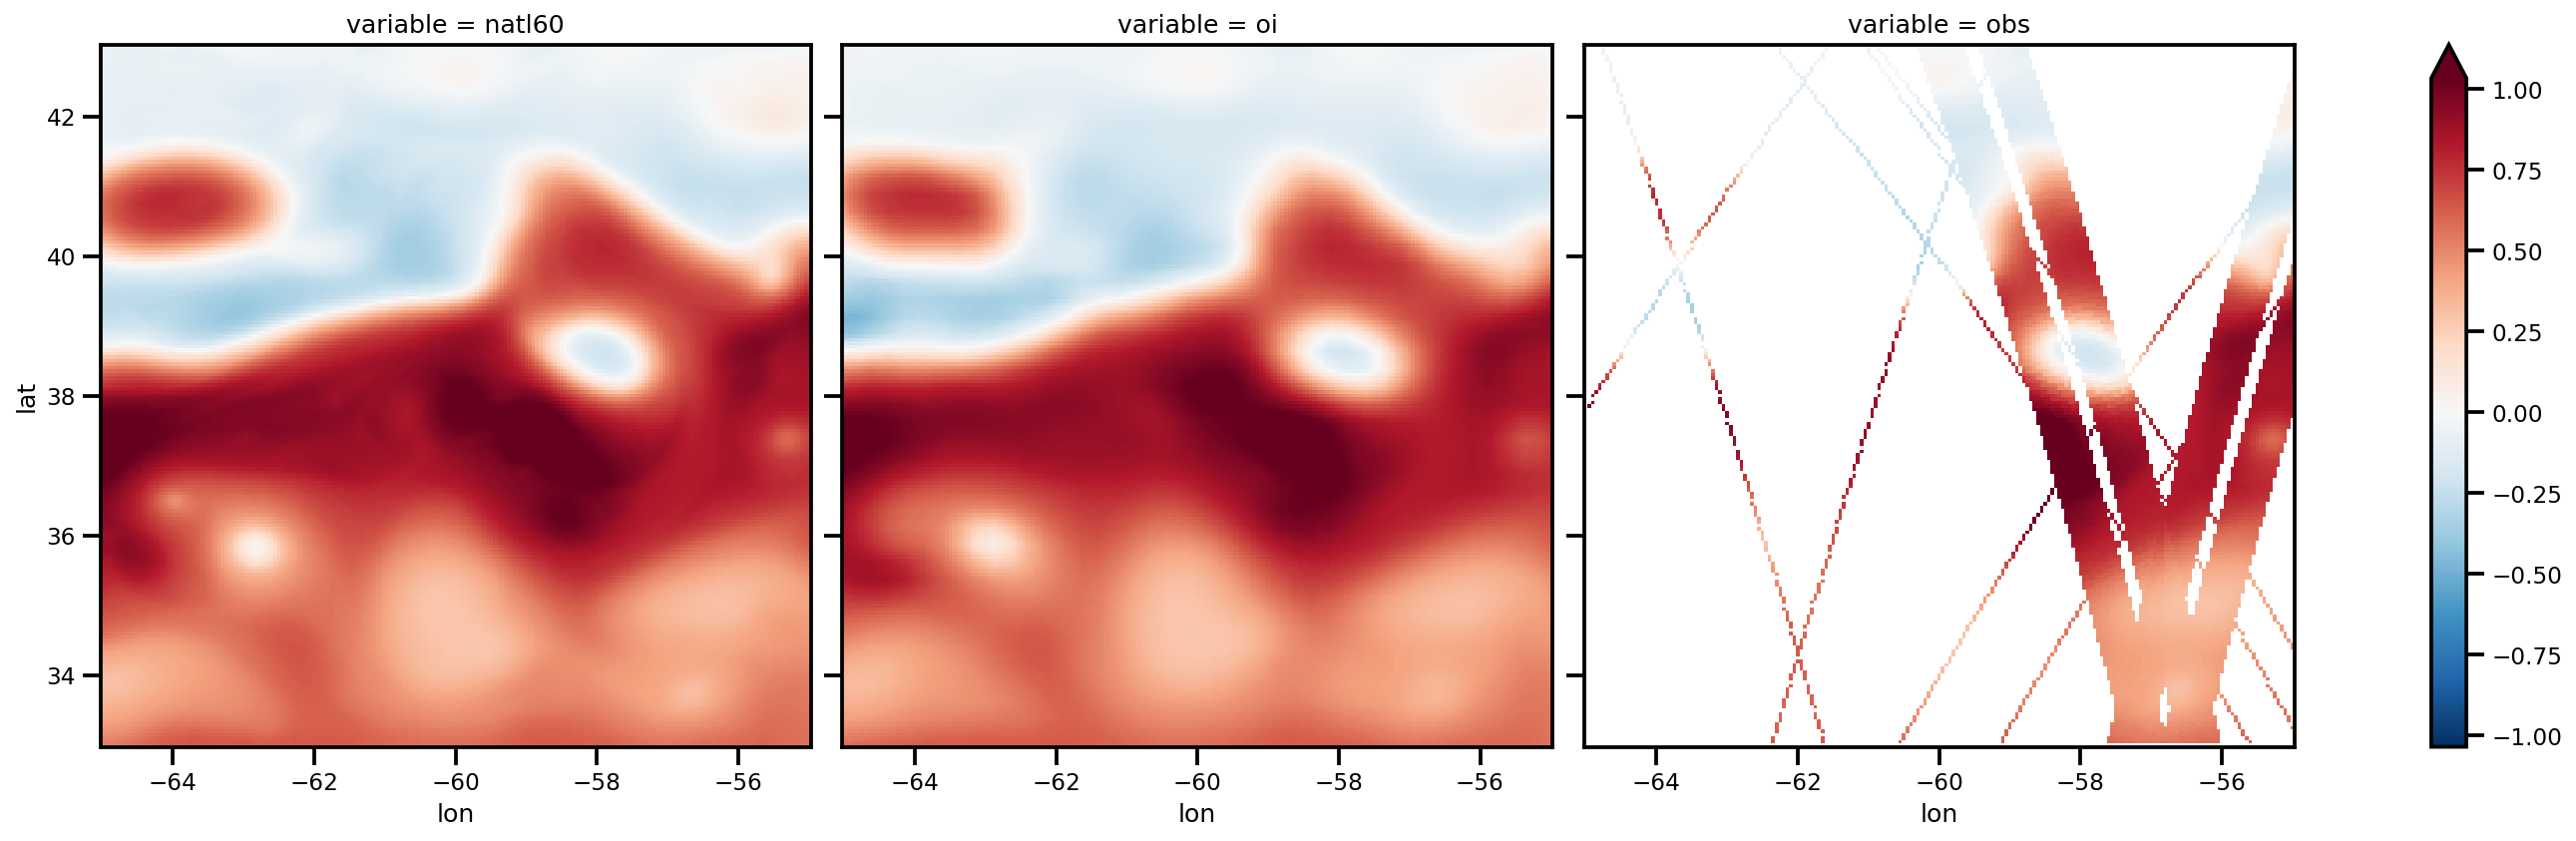

In [8]:
ds.to_array().isel(time=3).plot.pcolormesh(col='variable', figsize=(20, 6), robust=True)

### SSH Field Animation

In [9]:
# hv.extension('matplotlib')
# f = lambda da: da.isel(time=slice(25, 55, 1))
# ds = xr.Dataset({
#     'natl60': ref_ds.ssh,
#     'oi': oi_ds.ssh_mod,
#     'obs': obs_ds.ssh_mod,
# })
# # to_plot_ds = {"natl60": f(ref_ds.ssh), "oi": f(oi_ds.ssh_mod), "obs": f(obs_ds.ssh_mod)}
# # to_plot_ds = [f(ref_ds.ssh), f(oi_ds.ssh_mod), f(obs_ds.ssh_mod)]
# to_plot_ds = ds.isel(time=slice(25, 55, 1))
# clim = (
#     to_plot_ds[["natl60", "oi"]]
#     .to_array().pipe(lambda da: (da.quantile(0.005).item(), da.quantile(0.995).item()))
# )
# # clim=None
# images = hv.Layout([
#         hv.Dataset(to_plot_ds)
#         .to(hv.QuadMesh, ['lon', 'lat'], v).relabel(v)
#         .options(cmap='viridis', clim=clim)
#         for v in to_plot_ds
# ]).cols(3).opts(sublabel_format="")

# hv.output(images, holomap='gif', fps=2, dpi=125)

### Gradients

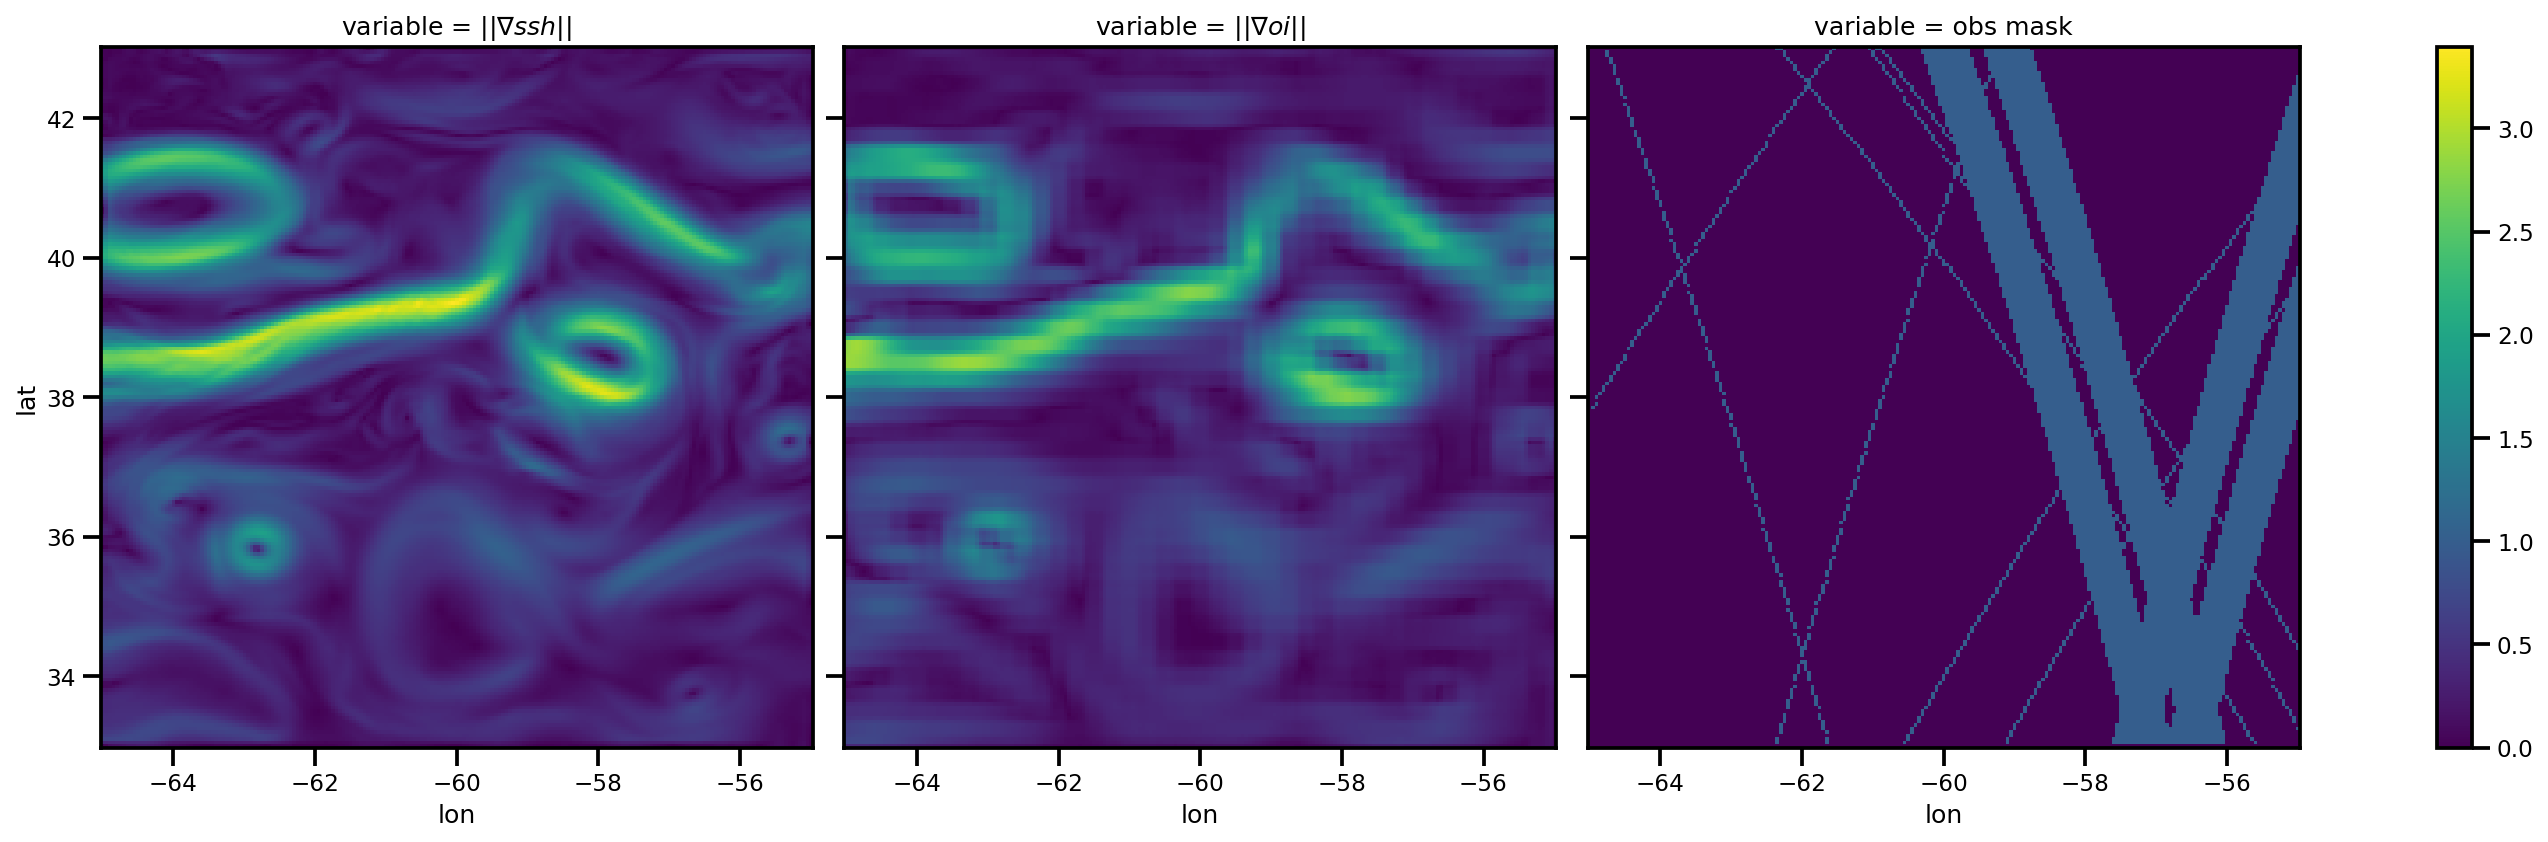

In [10]:
def sobel(da):
    dx = xr.apply_ufunc(lambda _da: ndimage.sobel(_da, -1), da)
    dy = xr.apply_ufunc(lambda _da: ndimage.sobel(_da, -2), da)
    return np.hypot(dx, dy)

grad_ds = xr.Dataset({
    r'||$\nabla ssh||$': ref_ds.ssh.pipe(sobel),
    r'||$\nabla oi||$': oi_ds.ssh_mod.pipe(sobel),
    'obs mask': np.isfinite(obs_ds.ssh_mod),
})
grad_ds.to_array().isel(time=3).plot.pcolormesh(col='variable', figsize=(20, 6), cmap='viridis')



### SSH Gradients Animation

In [11]:
# hv.extension('matplotlib')
# to_plot_ds = grad_ds.isel(time=slice(25, 55, 1))

# clim = (
#     to_plot_ds[[r'||$\nabla ssh||$', r'||$\nabla oi||$']]
#     .to_array().pipe(lambda da: (da.quantile(0.005).item(), da.quantile(0.995).item()))
# )
# images = hv.Layout([
#         hv.Dataset(to_plot_ds)
#         .to(hv.QuadMesh, ['lon', 'lat'], v).relabel(v)
#         .options(cmap='viridis',clim=clim)
#         for v in to_plot_ds
# ]).cols(3).opts(sublabel_format="")

# hv.output(images, holomap='gif', fps=2, dpi=125)

